In [9]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Processing /home/clement/Project/PhyloRNN/phyloRNN
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phyloRNN: filename=phylornn-0.41-py3-none-any.whl size=464289 sha256=213bcc333dade30e0e7371d676f27fa70b3588b05cfd89548e62089f24e8ba33
  Stored in directory: /tmp/pip-ephem-wheel-cache-9iutml0e/wheels/75/e5/f0/f031af9f02ec3ccd69c626c59d0ff6d65beb97028c575e91bf
Successfully built phyloRNN
  Attempting uninstall: phyloRNN
    Found existing installation: phyloRNN 0.41
    Uninstalling phyloRNN-0.41:
      Successfully uninstalled phyloRNN-0.41


In [1]:
import os
import matplotlib.pyplot as plt
import phyloRNN as pn
import sqlite3
import zlib
import numpy as np
import json
import tensorflow as tt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/clement/Project/PhyloRNN/phyloRNN/.devbox/nix/profile/default/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/clement/Project/PhyloRNN/phyloRNN/.devbox/nix/profile/default/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/clement/Project/PhyloRNN/phyloRNN/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/clement/Project/PhyloRNN/

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [11]:
print(tt.__version__)
print(np.__version__)

2.9.3
1.23.5


In [7]:
def plot_training_history(datum, show=True, save_path=None):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(datum)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
        
def train(fn, sqlite, taxa, site):

    training_file = os.path.join(os.getcwd(), fn)
    wd = os.path.dirname(training_file)
    model_name = "t50_s20"
    
    # load data
    sim, dict_inputs, dict_outputs = pn.rnn_in_out_dictionaries_from_sim(training_file,
                                                                         log_rates=False,
                                                                         log_tree_len=True,
                                                                         output_list=['per_site_rate','tree_len'],
                                                                         include_tree_features=False,
                                                                        sqlite = sqlite)
    
    # setup model architecture
    model_config = pn.rnn_config(n_sites=site, n_taxa=taxa) # default settings
    
    # build model
    model = pn.build_rnn_model(model_config,
                               optimizer=pn.keras.optimizers.RMSprop(1e-3),
                               print_summary=False)
    
    
    # training
    early_stop = pn.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5,
                                                  restore_best_weights=True)
    
    history = model.fit(dict_inputs, dict_outputs,
                        epochs=10,
                        validation_split=0.2,
                        verbose=2,
                        callbacks=[early_stop],
                        batch_size=100)
    
    # save model
    pn.save_rnn_model(wd=wd, history=history, model=model, filename=model_name)

    return history

def simulate():
    
    sim = pn.simulator(
                   n_taxa = 50,
                   n_sites = 1000,
                   n_eigen_features = 3,
                   min_rate = 0,  #
                   freq_uncorrelated_sites = 0.5,
                   freq_mixed_models = 0.05,
                   store_mixed_model_info = True,
                   tree_builder = 'nj',  # 'upgma'
        
                   subs_model_per_block = False,  # if false same subs model for all blocks
                   phyml_path = None,  # path to phyml and seq binaries
                   seqgen_path = None, # if None, it will try to use
                   ali_path = None,                                            # system-wide installed software
                   DEBUG=False,
                   verbose = True,
           format_output='sqlite')


        # training set
    sim.reset_prms(CPUs = 10,
                   n_sims = 2000,
                   data_name = "training_data_taxa_50_sites1000_20000",
                   base_seed = 1234)
    pn.simulate_parallel(sim, add_day_tag=False)

    

In [ ]:
simulate()


Running training_data_taxa_50_sites1000_20000
mean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_lengthmean_br_length         0.037838250267667455 0.0061295450881561570.075071222325714310.0091338325700394930.00533310305156212050.00177817858406049770.0010089334170165730.00060754529547183180.0003991614585748925
0.028397201725485505








simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating tree...done
simulating tree...done
simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating data...simulating tree...done
simulating data...done
simulating data...done
extracting features...done
mean_br_length 0.08496294465933192
simulating tree...done
simulating data...done
extracting features...done
mean_br_length 0.00031302540737771043
simulating tree...done
simulating

In [1]:
!ls -lht

total 732K
-rw-rw-r-- 1 clement clement  68K Feb 26 14:34 sqlite_batching.ipynb
-rw-rw-r-- 1 clement clement 5.0K Feb 26 11:42 batch_training.py
-rw-rw-r-- 1 clement clement 102K Feb 26 11:41 mprofile_20250226113606.dat
-rw-rw-r-- 1 clement clement 1.1K Feb 26 11:36 mprofile_20250226113600.dat
-rw-rw-r-- 1 clement clement 1.6K Feb 26 11:35 normal_training.py
-rw-rw-r-- 1 clement clement  84K Feb 26 11:35 mprofile_20250226113032.dat
-rw-rw-r-- 1 clement clement 115K Feb 26 11:31 mprofile_20250226112535.dat
-rw-rw-r-- 1 clement clement  11K Feb 26 11:24 mprofile_20250226112422.dat
-rw-rw-r-- 1 clement clement  11K Feb 26 11:21 mprofile_20250226112107.dat
-rw-rw-r-- 1 clement clement  11K Feb 26 11:19 mprofile_20250226111908.dat
-rw-rw-r-- 1 clement clement   25 Feb 25 11:26 pl.png
-rw-rw-r-- 1 clement clement  86K Feb 25 11:25 mprofile_20250225112111.dat
-rw-rw-r-- 1 clement clement 194K Feb 24 09:46 Explore_simulation_sqlite.ipynb
-rw-rw-r-- 1 clement clement 3.2K Dec 20 11:13 Monitor.i


peak memory: 3649.80 MiB, increment: 158.20 MiB
Creating blocks...
done
N. model parameters: 398675
Epoch 1/10
16/16 - 47s - loss: 1.7909 - per_site_rate_loss: 0.9817 - tree_len_loss: 0.8093 - val_loss: 3.3292 - val_per_site_rate_loss: 0.9056 - val_tree_len_loss: 2.4236 - 47s/epoch - 3s/step
Epoch 2/10
16/16 - 5s - loss: 1.8458 - per_site_rate_loss: 0.9669 - tree_len_loss: 0.8789 - val_loss: 1.5597 - val_per_site_rate_loss: 0.8814 - val_tree_len_loss: 0.6783 - 5s/epoch - 334ms/step
Epoch 3/10
16/16 - 5s - loss: 1.8710 - per_site_rate_loss: 0.9497 - tree_len_loss: 0.9213 - val_loss: 1.4313 - val_per_site_rate_loss: 0.8640 - val_tree_len_loss: 0.5674 - 5s/epoch - 334ms/step
Epoch 4/10
16/16 - 5s - loss: 1.5594 - per_site_rate_loss: 0.9357 - tree_len_loss: 0.6237 - val_loss: 1.4947 - val_per_site_rate_loss: 0.8572 - val_tree_len_loss: 0.6376 - 5s/epoch - 336ms/step
Epoch 5/10
16/16 - 5s - loss: 1.3318 - per_site_rate_loss: 0.9204 - tree_len_loss: 0.4114 - val_loss: 1.0846 - val_per_site_

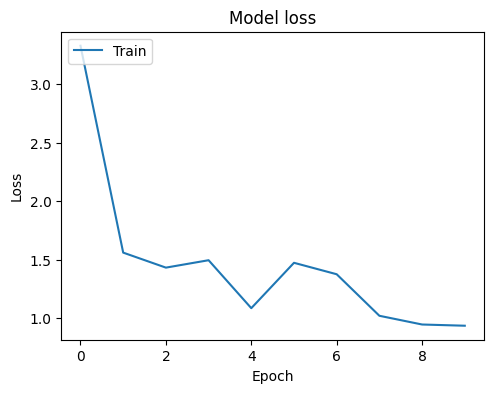

In [29]:
%mprun
training_file = os.path.join(os.getcwd(), '../data/training_data_taxa_20_sites200_2000.db')

# load data
%memit sim, dict_inputs, dict_outputs = pn.rnn_in_out_dictionaries_from_sim(training_file,log_rates=False,log_tree_len=True,output_list=['per_site_rate','tree_len'],include_tree_features=False,sqlite = True)

# setup model architecture
model_config = pn.rnn_config(n_sites=200, n_taxa=20) # default settings

# build model
model = pn.build_rnn_model(model_config, optimizer=pn.keras.optimizers.RMSprop(1e-3), print_summary=False)


# training
early_stop = pn.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

%memit history = model.fit(dict_inputs, dict_outputs,epochs=10,validation_split=0.2,verbose=2,callbacks=[early_stop],batch_size=100)

plot_training_history(history)

In [112]:

def sqlite_data_generator(db_path, batch_size):
    
    """Generator that loads data from an SQLite database in batches."""
    conn = sqlite3.connect(db_path)  # Connect to the database
    cursor = conn.cursor()

    # Retrieve data from array_info table
    array_info_dict = {}
    cursor.execute('SELECT name_, dtype, shape FROM array_info')

    for row in cursor.fetchall():
        name_, dtype, shape = row
        array_info_dict[name_] = {
            'dtype': dtype,
            'shape': eval(shape)[1:] # Remove the first dimension because its just the number of simulation
        }

   
    cursor.execute("SELECT COUNT(*) FROM simulation")
    total_samples = cursor.fetchone()[0]  # Get total number of rows
    
    for offset in range(0, total_samples, batch_size):
        
        # Query to get the data
        query = "SELECT features_ali, features_tree, labels_rates, labels_smodel, labels_tl, info FROM simulation  LIMIT ? OFFSET ?"
        cursor.execute( query,(batch_size, offset))
        rows = cursor.fetchall()
        
        if not rows:
            break  # Stop if no more data

        sim = {
            'features_ali': [],
            'features_tree': [],
            'labels_rates': [],
            'labels_smodel': [],
            'labels_tl': [],
            'info': []
        }

        def _decompdecode(e, dtype, shape=False):
            if shape:
                return np.frombuffer(zlib.decompress(e), dtype=dtype).reshape(shape)
            else:
                return np.frombuffer(zlib.decompress(e), dtype=dtype)

        for row in rows:
            sim['features_ali'].append(_decompdecode(row[0],array_info_dict['features_ali']['dtype'], array_info_dict['features_ali']['shape']))
            sim['features_tree'].append(_decompdecode(row[1],array_info_dict['features_tree']['dtype']))
            sim['labels_rates'].append(_decompdecode(row[2],array_info_dict['labels_rates']['dtype']) if row[2] else None)
            sim['labels_smodel'].append(_decompdecode(row[3],array_info_dict['labels_smodel']['dtype'], array_info_dict['labels_smodel']['shape']) if row[3] else None)
            sim['labels_tl'].append(_decompdecode(row[4],array_info_dict['labels_tl']['dtype'], array_info_dict['labels_tl']['shape']) if row[4] else None)
            sim['info'].append(np.array(json.loads(row[5])))

        # Tod this reshape could be avoided if we store the labels as a value instead single values array
        sim['labels_smodel'] = np.array(sim['labels_smodel']).reshape(len(sim['labels_smodel']))
        sim['labels_tl'] = np.array(sim['labels_tl']).reshape(len(sim['labels_tl']))

        sim, dict_inputs, dict_outputs = pn.rnn_in_out_dictionaries_from_sim(sim=sim,log_rates=False,log_tree_len=True,output_list=['per_site_rate','tree_len'],include_tree_features=False,sqlite = True)

        yield dict_inputs, dict_outputs

    conn.close()


In [ ]:
%mprun
training_file = os.path.join(os.getcwd(), '../data/training_data_taxa_20_sites200_2000.db')
batch_size = 50
steps_per_epoch = 2000 // batch_size

# setup model architecture
model_config = pn.rnn_config(n_sites=200, n_taxa=20) # default settings

# build model
model = pn.build_rnn_model(model_config, optimizer=pn.keras.optimizers.RMSprop(1e-3), print_summary=False)

# training
early_stop = pn.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

# Train using generator
history = model.fit(sqlite_data_generator("../data/training_data_taxa_20_sites200_2000.db", batch_size),steps_per_epoch=steps_per_epoch,epochs=10,verbose=2,callbacks=[early_stop],batch_size=batch_size)

plot_training_history(history)


Creating blocks...
done
N. model parameters: 398675
Epoch 1/20
1.8396590620279312 ----------------------------------------
Epoch 2/20
1.6293855011463165 ----------------------------------------
Epoch 3/20
1.3405855238437652 ----------------------------------------
Epoch 4/20
1.2229791715741158 ----------------------------------------
Epoch 5/20
1.1441507771611215 ----------------------------------------
Epoch 6/20
1.0806073039770125 ----------------------------------------
Epoch 7/20
1.0541773393750191 ----------------------------------------
Epoch 8/20
0.9974961683154107 ----------------------------------------
Epoch 9/20
0.9682034716010094 ----------------------------------------
Epoch 10/20
0.9646483659744263 ----------------------------------------
Epoch 11/20
0.9472708076238632 ----------------------------------------
Epoch 12/20
0.9329313665628434 ----------------------------------------
Epoch 13/20
0.9218773230910301 ----------------------------------------
Epoch 14/20
0.9186165

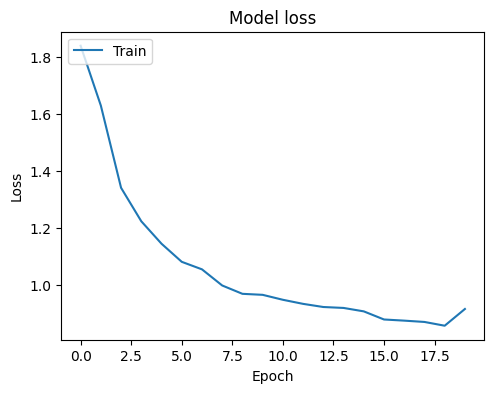

In [115]:
batch_size = 50
epochs = 20
steps_per_epoch = 2000 // batch_size

# setup model architecture
model_config = pn.rnn_config(n_sites=200, n_taxa=20) # default settings

# build model
model = pn.build_rnn_model(model_config, optimizer=pn.keras.optimizers.RMSprop(1e-3), print_summary=False)

# training
early_stop = pn.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

history = []  # Store loss and accuracy per epoch
best_val_loss = float("inf")
wait = 0  # Counter for early stopping
patience = 5

for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}/{epochs}")
    epoch_loss, num_batches = 0, 0

    batch_gen = sqlite_data_generator("../data/training_data_taxa_20_sites200_2000.db", batch_size)
    
    for X_batch, y_batch in batch_gen:
        t = model.train_on_batch(X_batch, y_batch)  # Train on a single batch
        epoch_loss += t[0]
        num_batches += 1

    epoch_loss = epoch_loss / num_batches

    history.append(epoch_loss)

    print(epoch_loss , "-" * 40)  # Separator between epochs

    # Early stopping check
    if history[-1] < best_val_loss:
        best_val_loss = history[-1]
        wait = 0  # Reset patience counter
    else:
        wait += 1  # Increment patience counter
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break  # Stop training

plot_training_history(history)